In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

## 1. Generate simulation data

In [193]:
def make_cube_points(size = 1.0, interval = 10):
    cube_pts = []
    colors = []
    num_in_edge = 2000

    # side views
    for i in range(interval+1):
        for j in range(num_in_edge):
            cube_pts.append([-size+size*2*i/interval,-size+size*2*j/num_in_edge,size])
            colors.append((255,0,0))
            cube_pts.append([-size+size*2*j/num_in_edge,-size+size*2*i/interval,size])
            colors.append((255,0,0))
            
            cube_pts.append([-size+size*2*i/interval,-size+size*2*j/num_in_edge,-size])
            colors.append((255,255,0))
            cube_pts.append([-size+size*2*j/num_in_edge,-size+size*2*i/interval,-size])
            colors.append((255,255,0))
            
            cube_pts.append([size,-size+size*2*i/interval, -size+size*2*j/num_in_edge])
            colors.append((0,255,0))
            cube_pts.append([size,-size+size*2*j/num_in_edge,-size+size*2*i/interval])
            colors.append((0,255,0))
            
            cube_pts.append([-size,-size+size*2*i/interval,-size+size*2*j/num_in_edge])
            colors.append((0,0,255))
            cube_pts.append([-size,-size+size*2*j/num_in_edge,-size+size*2*i/interval])
            colors.append((0,0,255))
    
    
    # top bottom views
    for i in range(interval+1):
        for j in range(num_in_edge):
            cube_pts.append([-size+size*2*i/interval,size,-size+size*2*j/num_in_edge])
            colors.append((255,0,255))
            cube_pts.append([-size+size*2*j/num_in_edge,size, -size+size*2*i/interval])
            colors.append((255,0,255))
            
            cube_pts.append([-size+size*2*i/interval, -size, -size+size*2*j/num_in_edge])
            colors.append((0,255,255))
            cube_pts.append([-size+size*2*j/num_in_edge,- size, -size+size*2*i/interval])
            colors.append((0,255,255))
    
    return cube_pts, colors

In [202]:
import open3d as o3d

cube_pts, colors = make_cube_points(5,10)
point_cloud_o3d = o3d.geometry.PointCloud()
point_cloud_o3d.points  = o3d.utility.Vector3dVector(cube_pts)
point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([point_cloud_o3d])

![image cube](images/cube.PNG)

## 2. Pinhole camera model

$$
\begin{bmatrix}uz\\vz\\z \end{bmatrix} = \begin{bmatrix}f_{x}&0&c_{x}\\0&f_{y}&c_{y}\\0&0&1 \end{bmatrix} \begin{bmatrix}x\\y\\z \end{bmatrix}
$$

$$
\begin{bmatrix}u\\v\end{bmatrix} = Homo(\begin{bmatrix}uz\\vz\\z \end{bmatrix})
$$

In [195]:
def project_point_to_pinhole(width, f, pts, colors):
    height = int(width*480/640)
    image = np.zeros((height, width, 3)) + 255
    #print(image.shape)
    #plt.imshow(image)
    cx = width/2
    cy = height/2

    for i in range(len(pts)):
        pt = pts[i]
        color = colors[i]
        
        if(pt[2] < 0.1):
            continue
        
        pt_u = int((pt[0] * f)/pt[2] + cx)
        pt_v = int((pt[1] * f)/pt[2] + cy)
        #print(pt[0], pt[1], pt_u, pt_v)
        if(pt_u < 0 or pt_u > width-1):
            continue
        if(pt_v < 0 or pt_v > height-1):
            continue
        #image[pt_v, pt_u] = 255
        cv2.circle(image,(pt_u,pt_v),3,color,-1)
    return image

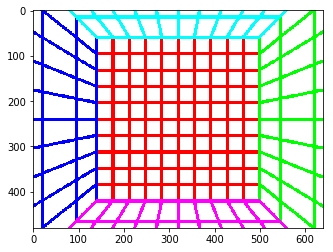

In [203]:
image = project_point_to_pinhole(640, 180, cube_pts, colors)
plt.imshow(image.astype(np.uint8))

## 3. Panorama camera model

$$
\begin{bmatrix}u\\v\end{bmatrix} = \begin{bmatrix}arcsin(u_{y})\\arctan2(u_{x}, u_{z})\end{bmatrix}
$$


In [197]:
def project_point_to_panorama_normal(height, pts, colors):
    width = height*2
    image = np.zeros((height, width, 3)) + 255
    for i in range(len(pts)):
        pt = pts[i]
        color = colors[i]
        
        pt /= np.linalg.norm(pt)
        pitch = np.arcsin(pt[1])
        yaw = np.arctan2(pt[0],pt[2])
        
        pt_u = int(width * (yaw /np.pi)/2 + width/2)
        pt_v = int(height * (pitch/np.pi) + height/2)
        cv2.circle(image,(pt_u,pt_v),3,color,-1)
    return image

True

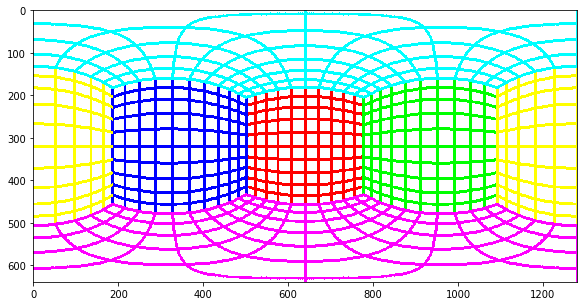

In [210]:
image = project_point_to_panorama_normal(640, cube_pts, colors)
plt.figure(figsize=(10,5))
plt.imshow(image.astype(np.uint8))
cv2.imwrite("panorama_1.jpg", image)

In [219]:
def project_point_to_panorama_special(height, offset, pts, colors):
    width = height*2
    image = np.zeros((height, width, 3)) + 255
    for i in range(len(pts)):
        pt = np.asarray(pts[i]) + np.asarray(offset)
        color = colors[i]
        
        pt /= np.linalg.norm(pt)
        pitch = np.arcsin(pt[1])
        yaw = np.arctan2(pt[0],pt[2])
        
        pt_u = int(width * (yaw /np.pi)/2 + width/2)
        pt_v = int(height * (pitch/np.pi) + height/2)
        cv2.circle(image,(pt_u,pt_v),3,color,-1)
    return image

True

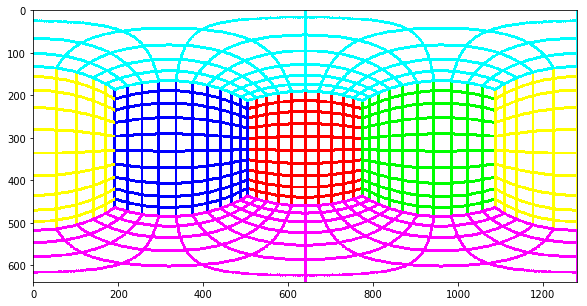

In [226]:
image = project_point_to_panorama_special(640, [0.0,0.3,0.0], cube_pts, colors)
plt.figure(figsize=(10,5))
plt.imshow(image.astype(np.uint8))
cv2.imwrite("panorama_2.jpg", image)